In [1]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from prettytable import PrettyTable

## Import the data

In [7]:
import pandas as pd
final = pd.read_csv("final.csv") #csv file which consists of Amazon food reviews with data cleaning performed upon previously
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(30000) #Gets 1000 reviews of positive and negative scores
neg_2000 = neg.sample(20000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (50000, 11)


Observations:
We choose 30000 positive and 20000 negative reviews from the final dataframe obtained after data cleaning process.

In [8]:
import datetime
grouped_data['Time'] = grouped_data['Time'].map(lambda a: datetime.datetime.fromtimestamp(int(a)).strftime('%Y-%m-%d %H:%M:%S'))
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

The shape of grouped data after time based splitting is (50000, 11)


Observations:
Time based splitting is done on the obtained dataframe.

In [ ]:
grouped_data.to_csv("grouped_data")

Observations:
Saving this dataframe into a new csv file.

# Utility Functions

In [2]:
#We create a few utility functions whose use is described below


def optimalk_brute(x_train,y_train,x_test,y_test): #This function finds optimal k with brute force algorithm.
    neighbors = list(filter(lambda a: a%2!=0, list(range(1,50)))) #This produces odd numbers from 1 to 50 as neighbours
    cv_scores=[]
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute') #This implements K nearest neighbours for brute force algorithm
        scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean()) #The mean of the obtained scores is taken
    
    MSE = [1 - x for x in cv_scores] #This lists the misclassification error for respective scores
    optimal_k = neighbors[MSE.index(min(MSE))] #Optimal k is calculated
    print('The optimal number of neighbors for brute force is: ',optimal_k)
    print("The Misclassification error for k = {} is: {}".format(optimal_k,np.round(min(MSE),3)))

    # Plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("The Misclassification error for each k value is : ", np.round(MSE,3))
    
    '''
    Find test accuracy
    '''
    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')
    knn_optimal.fit(x_train, y_train) # Fitting the model
    pred = knn_optimal.predict(x_test) # Predict the response
    acc = accuracy_score(y_test, pred) * 100 # Evaluate accuracy
    print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
    print("*"*50)
    
    '''
    Plot confusion matrix
    '''
    labels = ['Positive','Negative']
    cm = confusion_matrix(y_test,pred,labels)
    fig = plt.figure()
    sp = fig.add_subplot(111)
    csp = sp.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(csp)
    sp.set_xticklabels([''] + labels)
    sp.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("*"*50)
    
    '''
    Classification report
    '''
    print(classification_report(y_test,pred))
    
    
def optimalk_kdtree(x_train,y_train,x_test,y_test): #This function finds optimal k with kd tree algorithm.
    neighbors = list(filter(lambda a: a%2!=0, list(range(1,50)))) #This produces odd numbers from 1 to 50 as neighbours
    cv_scores=[]
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree') #This implements K nearest neighbours for kd tree algorithm
        scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean()) #The mean of the obtained scores is taken
    
    MSE = [1 - x for x in cv_scores] #This lists the misclassification error for respective scores
    optimal_k = neighbors[MSE.index(min(MSE))] #Optimal k is calculated
    print('The optimal number of neighbors for kd tree is: ',optimal_k)
    print("The Misclassification error for k = {} is: {}".format(optimal_k,np.round(min(MSE),3)))

    # Plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("The Misclassification error for each k value is : ", np.round(MSE,3))
    
    '''
    Find test accuracy
    '''
    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')
    knn_optimal.fit(x_train, y_train) # Fitting the model
    pred = knn_optimal.predict(x_test) # Predict the response
    acc = accuracy_score(y_test, pred) * 100 # Evaluate accuracy
    print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))
    print("*"*50)
    
    '''
    Plot confusion matrix
    '''
    labels = ['Positive','Negative']
    cm = confusion_matrix(y_test,pred,labels)
    fig = plt.figure()
    sp = fig.add_subplot(111)
    csp = sp.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(csp)
    sp.set_xticklabels([''] + labels)
    sp.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("*"*50)
    
    '''
    Classification report
    '''
    print(classification_report(y_test,pred))
    
    
def select_tsvd(data,var,comp): #This function finds the cumulative variance at a certain specified number of components.
    n=0
    tsvd = TruncatedSVD(n_components=comp) #Find Truncated SVD for the given components
    X_tsvd = tsvd.fit(data)
    tsvd_var_ratios = list(X_tsvd.explained_variance_ratio_.cumsum()) #List the variance ratios
    for a in tsvd_var_ratios:
        if a>=var: #Finds n at this variance
            n = tsvd_var_ratios.index(a)+1 #This finds the n value at the given variance
            break
    if n!=0:
        print("The number of components is: ",n)
    print("The final vaue of cumulative variance is",tsvd_var_ratios[-1])

**Observations:**

1) We define two functions which splits the dataframe into train, cv and test and finds the optimal k for the respective algorithm.

2) It then plots the number of neighbours vs misclassification error graph for visualisation.

3) Then it predicts the test accuracy of the algorithm and returns the results.

4) Also it plots the confusion matrix.

5) The third function gets the optimal n value for performing dimensionality reductioon

# Bag of Words

In [19]:
import pandas as pd
grouped_data = pd.read_csv("grouped_data.csv")
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

The shape of grouped data after time based splitting is (50000, 12)


Observations:
A csv file is imported which consists of 50000 data points. These data points are already sorted on the basis of time.

In [20]:
x_1, x_test, y_1, y_test = cross_validation.train_test_split(grouped_data, scores, test_size=0.3, random_state=0)
x_train, x_cv, y_train, y_cv = cross_validation.train_test_split(x_1, y_1, test_size=0.3)

Observations:
The data is split into train, test and cross validate.

In [21]:
count_vect = CountVectorizer()
vocab = count_vect.fit(x_train['CleanedText'].values)
data_train = count_vect.transform(x_train['CleanedText'].values)
data_test = count_vect.transform(x_test['CleanedText'].values)
print("The shape of train data for BOW is {}".format(data_train.shape))
print("The shape of test data for BOW is {}".format(data_test.shape))

The shape of train data for BOW is (24500, 20066)
The shape of test data for BOW is (15000, 20066)


Observations:
We build out Bag of words vocabulary only on train data and get vectors of train and test data.

In [22]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
standard_train = StandardScaler(with_mean=False).fit_transform(data_train)
standard_test = StandardScaler(with_mean=False).fit_transform(data_test)
print("The type of standard_train is ",type(data_train))
print("The type of standard_test is ",type(data_test))
print("The shape of standard_train is ",standard_train.get_shape())
print("The shape of standard_test is ",standard_test.get_shape())

The type of standard_train is  <class 'scipy.sparse.csr.csr_matrix'>
The type of standard_test is  <class 'scipy.sparse.csr.csr_matrix'>
The shape of standard_train is  (24500, 20066)
The shape of standard_test is  (15000, 20066)


Observations:
The data is standardized.

The optimal number of neighbors for brute force is:  7
The Misclassification error for k = 7 is: 0.302


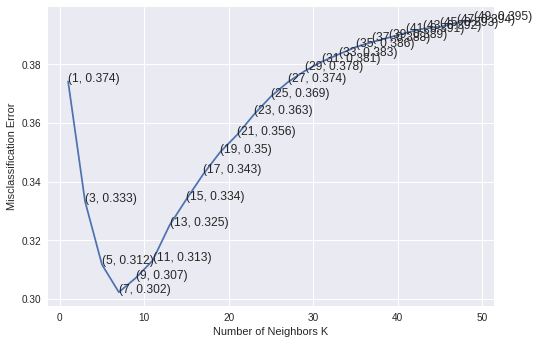

The Misclassification error for each k value is :  [0.374 0.333 0.312 0.302 0.307 0.313 0.325 0.334 0.343 0.35  0.356 0.363
 0.369 0.374 0.378 0.381 0.383 0.386 0.388 0.389 0.391 0.392 0.393 0.394
 0.395]

The accuracy of the knn classifier for k = 7 is 69.826667%
**************************************************


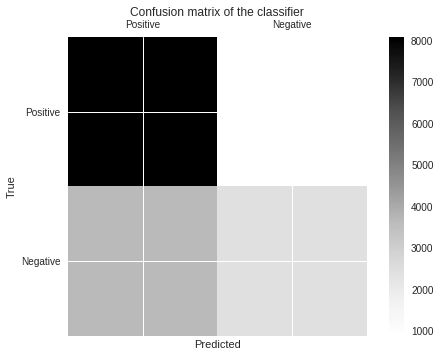

**************************************************
             precision    recall  f1-score   support

   Negative       0.73      0.40      0.51      6041
   Positive       0.69      0.90      0.78      8959

avg / total       0.71      0.70      0.67     15000



In [9]:
optimalk_brute(standard_train, y_train, standard_test, y_test)

In [23]:
import pandas as pd
import datetime
final = pd.read_csv("grouped_data_20k.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(4000) #Gets 1000 reviews of positive and negative scores
neg_2000 = neg.sample(3000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data['Time'] = grouped_data['Time'].map(lambda a: datetime.datetime.fromtimestamp(int(a)).strftime('%Y-%m-%d %H:%M:%S'))
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

The shape of grouped data after time based splitting is (7000, 11)


Observations:
We import a csv file containing 20000 data points, get 4000 positive and 3000 negative points to form another dataframe.
This is then split and sorted on the basis of time.

In [25]:
x_1, x_test, y_1, y_test = cross_validation.train_test_split(grouped_data, scores, test_size=0.3, random_state=0)
x_train, x_cv, y_train, y_cv = cross_validation.train_test_split(x_1, y_1, test_size=0.3)

Observations:
The data is split into train, test and cross validate.

In [26]:
count_vect = CountVectorizer()
vocab = count_vect.fit(x_train['CleanedText'].values)
data_train = count_vect.transform(x_train['CleanedText'].values)
data_test = count_vect.transform(x_test['CleanedText'].values)
print("The shape of train data for BOW is {}".format(data_train.shape))
print("The shape of test data for BOW is {}".format(data_test.shape))

The shape of train data for BOW is (3430, 8207)
The shape of test data for BOW is (2100, 8207)


Observations:
We build out Bag of words vocabulary only on train data and get vectors of train and test data.

In [28]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
standard_train = StandardScaler(with_mean=False).fit_transform(data_train)
standard_test = StandardScaler(with_mean=False).fit_transform(data_test)
print("The type of standard_train is ",type(data_train))
print("The type of standard_test is ",type(data_test))
print("The shape of standard_train is ",standard_train.get_shape())
print("The shape of standard_test is ",standard_test.get_shape())

The type of standard_train is  <class 'scipy.sparse.csr.csr_matrix'>
The type of standard_test is  <class 'scipy.sparse.csr.csr_matrix'>
The shape of standard_train is  (3430, 8207)
The shape of standard_test is  (2100, 8207)


Observations:
The data is standardized.

In [29]:
select_tsvd(standard_train,0.20,400)

The number of components is:  80
The final vaue of cumulative variance is 0.47485592158763223


Observations: We find the variance at given number of components and select the right n_components value.

In [30]:
svd = TruncatedSVD(n_components = 400)
red_train = svd.fit_transform(standard_train)
print('The shape of train data after dimensionality reduction is',red_train.shape)

The shape of train data after dimensionality reduction is (3430, 400)


Observations: Dimensionality reduction is performed upon train data.

In [31]:
svd = TruncatedSVD(n_components = 400)
red_test = svd.fit_transform(standard_test)
print('The shape of test data after dimensionality reduction is',red_test.shape)

The shape of test data after dimensionality reduction is (2100, 400)


Observations: Dimensionality reduction is performed upon test data.

The optimal number of neighbors for kd tree is:  17
The Misclassification error for k = 17 is: 0.327


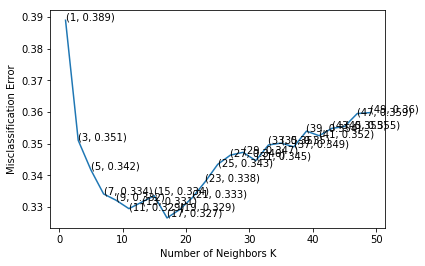

The Misclassification error for each k value is :  [0.389 0.351 0.342 0.334 0.332 0.329 0.331 0.334 0.327 0.329 0.333 0.338
 0.343 0.346 0.347 0.345 0.35  0.35  0.349 0.354 0.352 0.355 0.355 0.359
 0.36 ]

The accuracy of the knn classifier for k = 17 is 56.714286%
**************************************************


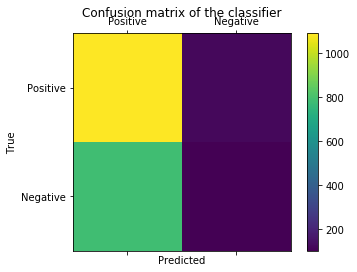

**************************************************
             precision    recall  f1-score   support

   Negative       0.45      0.11      0.18       888
   Positive       0.58      0.90      0.71      1212

avg / total       0.53      0.57      0.48      2100



In [32]:
optimalk_kdtree(red_train,y_train,red_test,y_test)

# TFIDF

In [35]:
import pandas as pd
grouped_data = pd.read_csv("grouped_data.csv")
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

The shape of grouped data after time based splitting is (50000, 12)


Observations:
A csv file is imported which consists of 50000 data points. These data points are already sorted on the basis of time.

In [37]:
x_1, x_test, y_1, y_test = cross_validation.train_test_split(grouped_data, scores, test_size=0.3, random_state=0)
x_train, x_cv, y_train, y_cv = cross_validation.train_test_split(x_1, y_1, test_size=0.3)

Observations: Data is split into train, test and cross validate

In [38]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab_tf_idf = tf_idf_vect.fit(x_train['CleanedText'].values) #Converts to a sparse matrix of TF-IDF vectors.
train_tf_idf = tf_idf_vect.transform(x_train['CleanedText'].values)
test_tf_idf = tf_idf_vect.transform(x_test['CleanedText'].values)
print("the type of count vectorizer ",type(train_tf_idf))
print("The shape of train_tf_idf ",train_tf_idf.get_shape())
print("The shape of test_tf_idf ", test_tf_idf.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train_tf_idf  (24500, 482178)
The shape of test_tf_idf  (15000, 482178)


Observations:
Vocabulary of TF-IDF is trained for train data and vectors for train and test data are obtained.

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
standardized_train = StandardScaler(with_mean=False).fit_transform(train_tf_idf) #It gets the mean, variance and performs standardization.
standardized_test = StandardScaler(with_mean=False).fit_transform(test_tf_idf)
print("The shape of standardized train data is",standardized_train.shape)
print("The shape of standardized test data is",standardized_test.shape)

The shape of standardized train data is (24500, 482178)
The shape of standardized test data is (15000, 482178)


Observations:
Data is standardized.

The optimal number of neighbors for brute force is:  3
The Misclassification error for k = 3 is: 0.396


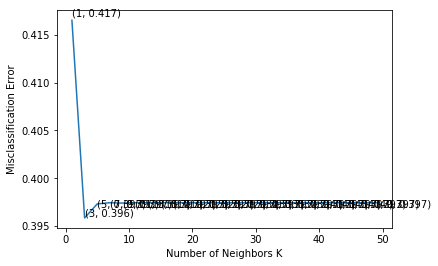

The Misclassification error for each k value is :  [0.417 0.396 0.397 0.397 0.397 0.397 0.397 0.397 0.397 0.397 0.397 0.397
 0.397 0.397 0.397 0.397 0.397 0.397 0.397 0.397 0.397 0.397 0.397 0.397
 0.397]

The accuracy of the knn classifier for k = 3 is 59.933333%
**************************************************


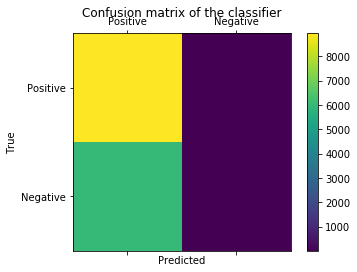

**************************************************
             precision    recall  f1-score   support

   Negative       0.82      0.01      0.01      6041
   Positive       0.60      1.00      0.75      8959

avg / total       0.69      0.60      0.45     15000



In [40]:
optimalk_brute(standardized_train,y_train,standardized_test,y_test)

In [17]:
import pandas as pd
import datetime
final = pd.read_csv("grouped_data_20k.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(4000) #Gets 1000 reviews of positive and negative scores
neg_2000 = neg.sample(3000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data['Time'] = grouped_data['Time'].map(lambda a: datetime.datetime.fromtimestamp(int(a)).strftime('%Y-%m-%d %H:%M:%S'))
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

The shape of grouped data after time based splitting is (7000, 11)


Observations:
We import a csv file containing 20000 data points, get 4000 positive and 3000 negative points to form another dataframe.
This is then split and sorted on the basis of time.

In [18]:
x_1, x_test, y_1, y_test = cross_validation.train_test_split(grouped_data, scores, test_size=0.3, random_state=0)
x_train, x_cv, y_train, y_cv = cross_validation.train_test_split(x_1, y_1, test_size=0.3)

Observations: Data is split into train, test and cross validate.

In [19]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab_tf_idf = tf_idf_vect.fit(x_train['CleanedText'].values) #Converts to a sparse matrix of TF-IDF vectors.
train_tf_idf = tf_idf_vect.transform(x_train['CleanedText'].values)
test_tf_idf = tf_idf_vect.transform(x_test['CleanedText'].values)
print("the type of count vectorizer ",type(train_tf_idf))
print("The shape of train_tf_idf ",train_tf_idf.get_shape())
print("The shape of test_tf_idf ", test_tf_idf.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train_tf_idf  (3430, 104876)
The shape of test_tf_idf  (2100, 104876)


Observations:
Vocabulary of TF-IDF is trained for train data and vectors for train and test data are obtained.

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
standardized_train = StandardScaler(with_mean=False).fit_transform(train_tf_idf) #It gets the mean, variance and performs standardization.
standardized_test = StandardScaler(with_mean=False).fit_transform(test_tf_idf)
print("The shape of standardized train data is",standardized_train.shape)
print("The shape of standardized test data is",standardized_test.shape)

The shape of standardized train data is (3430, 104876)
The shape of standardized test data is (2100, 104876)


Observations:
The data is standardized.

In [25]:
select_tsvd(standardized_train,0.40,600)

The number of components is:  505
The final vaue of cumulative variance is 0.43991216315449194


Observations: We find the variance at given number of components and select the right n_components value.

In [26]:
svd = TruncatedSVD(n_components = 600)
red_train = svd.fit_transform(standardized_train)
print('The shape of train data after dimensionality reduction is',red_train.shape)

The shape of train data after dimensionality reduction is (3430, 600)


Observations: Dimensionality reduction is performed upon train data.

In [27]:
svd = TruncatedSVD(n_components = 600)
red_test = svd.fit_transform(standardized_test)
print('The shape of train data after dimensionality reduction is',red_test.shape)

The shape of train data after dimensionality reduction is (2100, 600)


Observations: Dimensionality reduction is performed upon test data.

The optimal number of neighbors for kd tree is:  9
The Misclassification error for k = 9 is: 0.369


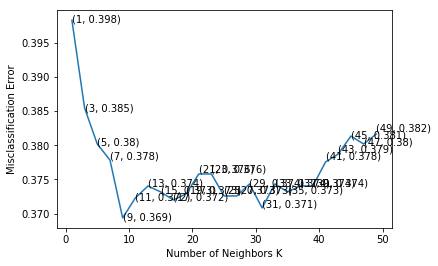

The Misclassification error for each k value is :  [0.398 0.385 0.38  0.378 0.369 0.372 0.374 0.373 0.372 0.373 0.376 0.376
 0.373 0.373 0.374 0.371 0.374 0.373 0.374 0.374 0.378 0.379 0.381 0.38
 0.382]

The accuracy of the knn classifier for k = 9 is 55.523810%
**************************************************


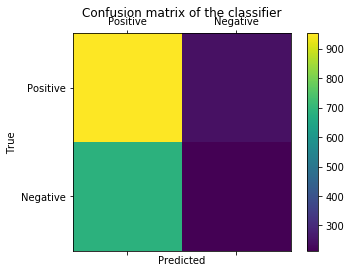

**************************************************
             precision    recall  f1-score   support

   Negative       0.47      0.24      0.31       902
   Positive       0.58      0.79      0.67      1198

avg / total       0.53      0.56      0.52      2100



In [28]:
optimalk_kdtree(red_train,y_train,red_test,y_test)

# Word2Vec

In [0]:
import pandas as pd
grouped_data = pd.read_csv("grouped_data.csv")
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

The shape of grouped data is (50000, 11)


Observations:
A csv file is imported which consists of 50000 data points. These data points are already sorted on the basis of time.

In [15]:
x_1, x_test, y_1, y_test = cross_validation.train_test_split(grouped_data, scores, test_size=0.3, random_state=0)
x_train, x_cv, y_train, y_cv = cross_validation.train_test_split(x_1, y_1, test_size=0.3)

Observations: The data is split into train, test and cross validate.

In [16]:
list_of_sent=[]
for sent in x_train['CleanedText'].values: #Splits sentences into words and stores it in a list
    list_of_sent.append(sent.split())
print(x_train['CleanedText'].values[9])
print("*****************************************************************")
print(list_of_sent[9])

sent christma present amaz hear recipi arriv well christma report pear arriv perfect condit delici
*****************************************************************
['sent', 'christma', 'present', 'amaz', 'hear', 'recipi', 'arriv', 'well', 'christma', 'report', 'pear', 'arriv', 'perfect', 'condit', 'delici']


Observations:
Prints the corresponding split words in a given review.

In [17]:
w2v_train=Word2Vec(list_of_sent,min_count=5,size=200, workers=4) #Initialises the Word2Vec model with words occuring more than 5 times.

w2v_train_words = list(w2v_train.wv.vocab) #This gives a dictionary of words which tells about the uniqueness of a word among other things.
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[298:315])

number of words that occured minimum 5 times  6976
sample words  ['scour', 'pic', 'vosg', 'declin', 'upon', 'stout', 'speci', 'squid', 'unnatur', 'anymor', 'power', 'safflow', 'bomb', 'compact', 'boat', 'photo', 'needl']


Observations:
Word2Vec model is built. We can see the number of times a word occured minimum 5 times.

In [0]:
sent_vectors = [];
sent_list = []
for sent in x_test['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(200) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            vec = w2v_train.wv[word] #Gets the corresponding vector for the word
            sent_vec += vec
            i += 1
    if i != 0:
        sent_vec /= i
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

15000
200


Observations: Obtain the vector form of test data.

In [0]:
sent_vectors_train = [];
sent_list = []
for sent in x_train['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(200) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            vec = w2v_train.wv[word] #Gets the corresponding vector for the word
            sent_vec += vec
            i += 1
    if i != 0:
        sent_vec /= i
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

24500
200


Observations: Obtain the vector form of train data.

In [0]:
from sklearn.preprocessing import StandardScaler
standardized_train = StandardScaler(with_mean=False).fit_transform(sent_vectors_train) #This standardises the list of vectors.
standardized_test = StandardScaler(with_mean=False).fit_transform(sent_vectors) #This standardises the list of vectors.

Observations:
Data is standardized.

The optimal number of neighbors for brute force is:  37
The Misclassification error for k = 37 is: 0.197


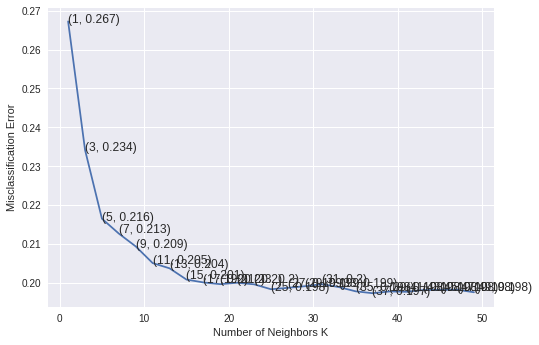

The Misclassification error for each k value is :  [0.267 0.234 0.216 0.213 0.209 0.205 0.204 0.201 0.2   0.2   0.2   0.2
 0.198 0.199 0.199 0.2   0.199 0.198 0.197 0.198 0.198 0.198 0.198 0.198
 0.198]

The accuracy of the knn classifier for k = 37 is 80.106667%
**************************************************


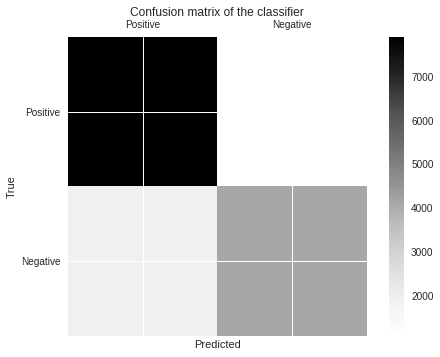

**************************************************
             precision    recall  f1-score   support

   Negative       0.79      0.68      0.73      6018
   Positive       0.81      0.88      0.84      8982

avg / total       0.80      0.80      0.80     15000



In [0]:
optimalk_brute(standardized_train,y_train,standardized_test,y_test)

In [0]:
select_tsvd(standardized_train,0.90)

The number of components is:  21


Observations: The right value of n_components for the wanted variance.

In [0]:
select_tsvd(standardized_test,0.90)

The number of components is:  21


Observations: The right value of n_components for the wanted variance.

In [0]:
svd = TruncatedSVD(n_components = 21, n_iter = 100)
red_train = svd.fit_transform(standardized_train)
red_test = svd.fit_transform(standardized_test)
print("The shape of reduced train data is ",red_train.shape)
print("The shape of reduced test data is ",red_test.shape)

The shape of reduced train data is  (24500, 21)
The shape of reduced test data is  (15000, 21)


Observations: Dimensionality reduction is performed upon train and test data.

The optimal number of neighbors for kd tree is:  47
The Misclassification error for k = 47 is: 0.193


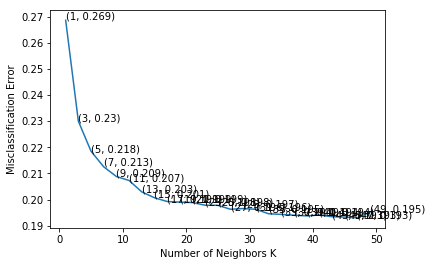

The Misclassification error for each k value is :  [0.269 0.23  0.218 0.213 0.209 0.207 0.203 0.201 0.199 0.199 0.199 0.198
 0.198 0.196 0.197 0.196 0.195 0.194 0.194 0.194 0.194 0.193 0.193 0.193
 0.195]

The accuracy of the knn classifier for k = 47 is 67.800000%
**************************************************


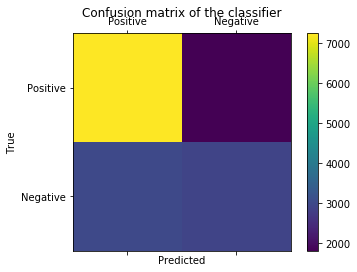

**************************************************
             precision    recall  f1-score   support

   Negative       0.62      0.49      0.55      5942
   Positive       0.71      0.80      0.75      9058

avg / total       0.67      0.68      0.67     15000



In [0]:
optimalk_kdtree(red_train,y_train,red_test,y_test)

# TF-IDF Word2Vec

In [3]:
import pandas as pd
import datetime
final = pd.read_csv("grouped_data_20k.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(6000) #Gets 1000 reviews of positive and negative scores
neg_2000 = neg.sample(4000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data['Time'] = grouped_data['Time'].map(lambda a: datetime.datetime.fromtimestamp(int(a)).strftime('%Y-%m-%d %H:%M:%S'))
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

The shape of grouped data after time based splitting is (10000, 11)


Observations:
Import a csv file containing 20000 data points and form a new dataframe with 10000 data points containing 6000 positive and 4000 negative points. Time based splitting is performed upon.

In [4]:
x_1, x_test, y_1, y_test = cross_validation.train_test_split(grouped_data, scores, test_size=0.3, random_state=0)
x_train, x_cv, y_train, y_cv = cross_validation.train_test_split(x_1, y_1, test_size=0.3)

Observations: Data is split into train, test and cross validate.

In [5]:
list_of_sent=[]
for sent in x_train['CleanedText'].values: #Splits sentences into words and stores it in a list
    list_of_sent.append(sent.split())
print(x_train['CleanedText'].values[9])
print("*****************************************************************")
print(list_of_sent[9])

love keurig one favorit flavor tast smell chocol raspberri pair good creamer love cup coffe heaven keurig differnt flavor
*****************************************************************
['love', 'keurig', 'one', 'favorit', 'flavor', 'tast', 'smell', 'chocol', 'raspberri', 'pair', 'good', 'creamer', 'love', 'cup', 'coffe', 'heaven', 'keurig', 'differnt', 'flavor']


Observations:
Prints the corresponding split words in a given review.

In [6]:
w2v_train=Word2Vec(list_of_sent,min_count=5,size=100, workers=4) #Initialises the Word2Vec model with words occuring more than 5 times.

w2v_train_words = list(w2v_train.wv.vocab) #This gives a dictionary of words which tells about the uniqueness of a word among other things.
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[298:315])

number of words that occured minimum 5 times  3327
sample words  ['insulin', 'vegetarian', 'decreas', 'toxin', 'fresher', 'shop', 'rees', 'magnesium', 'profil', 'fail', 'soap', 'element', 'today', 'bay', 'artichok', 'honest', 'dispos']


Observations:
Word2Vec model is built. We can see the number of times a word occured minimum 5 times.

In [7]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab_tf_idf = tf_idf_vect.fit(x_train['CleanedText'].values) #Converts to a sparse matrix of TF-IDF vectors.
train_tf_idf = tf_idf_vect.transform(x_train['CleanedText'].values)
test_tf_idf = tf_idf_vect.transform(x_test['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names()

Observations:
We build the vocabulary of TF-IDF on train data and obtain the vectors of train and test data.

In [8]:
sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
sent_list = []
for sent in x_train['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_train_words:
            try:
                vec = w2v_train.wv[word] # obtain the tf_idfidf of a word in a sentence/review
                tf_idf = train_tf_idf[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_train.append(sent_vec)
    row += 1
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

4900
100


Observations:
The vector form of train data is obtained.

In [10]:
sent_vectors_test = [];
row=0
sent_list = []
for sent in x_test['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(100) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            try:
                vec = w2v_train.wv[word] #Gets the corresponding vector for the word
                tf_idf = test_tf_idf[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                i += tf_idf
            except:
                pass
    if i != 0:
        sent_vec /= i
    sent_vectors_test.append(sent_vec)
    row+=1
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

3000
100


Observations:
The vector form of test data is obtained.

In [11]:
from sklearn.preprocessing import StandardScaler
standardized_train = StandardScaler(with_mean=False).fit_transform(sent_vectors_train) #This standardises the list of vectors.
standardized_test = StandardScaler(with_mean=False).fit_transform(sent_vectors_test) #This standardises the list of vectors.

Observations: Data is standardized.

The optimal number of neighbors for brute force is:  49
The Misclassification error for k = 49 is: 0.354


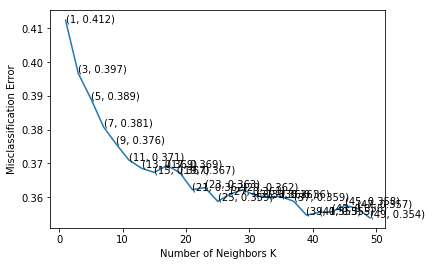

The Misclassification error for each k value is :  [0.412 0.397 0.389 0.381 0.376 0.371 0.369 0.367 0.369 0.367 0.362 0.363
 0.359 0.361 0.362 0.36  0.36  0.36  0.359 0.355 0.355 0.356 0.358 0.357
 0.354]

The accuracy of the knn classifier for k = 49 is 63.366667%
**************************************************


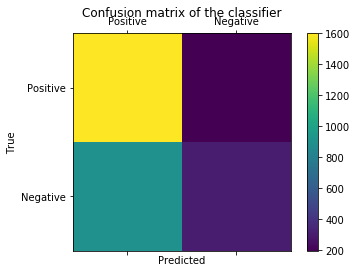

**************************************************
             precision    recall  f1-score   support

   Negative       0.61      0.25      0.35      1206
   Positive       0.64      0.89      0.74      1794

avg / total       0.63      0.63      0.59      3000



In [12]:
optimalk_brute(standardized_train,y_train,standardized_test,y_test)

In [14]:
select_tsvd(standardized_train,0.90,99)

The number of components is:  3
The final vaue of cumulative variance is 0.9999990655630695


Observations: Selecting the right value of n_components.

In [15]:
svd = TruncatedSVD(n_components=70)
red_train = svd.fit_transform(standardized_train)
red_test = svd.fit_transform(standardized_test)
print("The shape of reduced train data is ",red_train.shape)
print("The shape of reduced test data is ",red_test.shape)

The shape of reduced train data is  (4900, 70)
The shape of reduced test data is  (3000, 70)


Observations:
The dimensions of train and test data are reduced to 70.

The optimal number of neighbors for kd tree is:  49
The Misclassification error for k = 49 is: 0.354


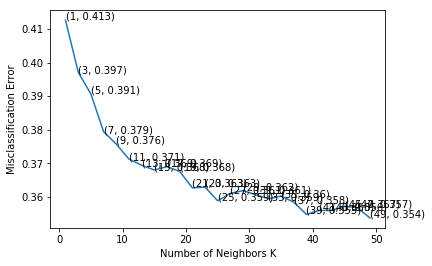

The Misclassification error for each k value is :  [0.413 0.397 0.391 0.379 0.376 0.371 0.369 0.368 0.369 0.368 0.363 0.363
 0.359 0.361 0.362 0.361 0.359 0.36  0.358 0.355 0.356 0.356 0.357 0.357
 0.354]

The accuracy of the knn classifier for k = 49 is 55.066667%
**************************************************


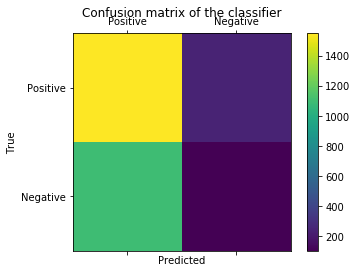

**************************************************
             precision    recall  f1-score   support

   Negative       0.30      0.09      0.13      1206
   Positive       0.58      0.86      0.70      1794

avg / total       0.47      0.55      0.47      3000



In [16]:
optimalk_kdtree(red_train,y_train,red_test,y_test)

# Conclusion

In [6]:
x = PrettyTable()
x.field_names = ["Model","Algorithm", "Hyper Parameter", "Misclassification error", "Test Accuracy"]
x.add_row(["Bag of Words","Brute","k = 7",0.302,"69.83%"])
x.add_row([" ","KD Tree","k = 17",0.327,"56.71%"])
x.add_row(["","","","",""])
x.add_row(["TF-IDF","Brute","k = 3",0.396,"59.93%"])
x.add_row([" ","KD Tree","k = 9",0.369,"55.52%"])
x.add_row(["","","","",""])
x.add_row(["Word2Vec","Brute","k = 37",0.197,"80.11%"])
x.add_row([" ","KD Tree","k = 47",0.193,"67.80%"])
x.add_row(["","","","",""])
x.add_row(["TF-IDF Word2Vec","Brute","k = 49",0.354,"63.37%"])
x.add_row([" ","KD Tree","k = 49",0.354,"55.10%"])
print(x.get_string())

+-----------------+-----------+-----------------+-------------------------+---------------+
|      Model      | Algorithm | Hyper Parameter | Misclassification error | Test Accuracy |
+-----------------+-----------+-----------------+-------------------------+---------------+
|   Bag of Words  |   Brute   |      k = 7      |          0.302          |     69.83%    |
|                 |  KD Tree  |      k = 17     |          0.327          |     56.71%    |
|                 |           |                 |                         |               |
|      TF-IDF     |   Brute   |      k = 3      |          0.396          |     59.93%    |
|                 |  KD Tree  |      k = 9      |          0.369          |     55.52%    |
|                 |           |                 |                         |               |
|     Word2Vec    |   Brute   |      k = 37     |          0.197          |     80.11%    |
|                 |  KD Tree  |      k = 47     |          0.193          |     